<a href="https://colab.research.google.com/github/krishghiya/Object-Detection/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Acquisition and Preprocessing

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg

path = Path(keras.utils.get_file(fname="master.zip", origin="https://github.com/thsant/wgisd/archive/master.zip", extract=True))

1311793152/Unknown - 49s 0us/step

In [ ]:
folder = path.parent / 'wgisd-master'
data_dir = folder / 'data'

os.listdir(folder)

['test.txt',
 'README.md',
 'test_masked.txt',
 'train.txt',
 'classes.txt',
 'README.org',
 'data',
 'original_resolution',
 'WGISD.ipynb',
 'train_masked.txt']

In [ ]:
train_files = [name.strip() for name in open(folder / 'train.txt').readlines()]
test_files = [name.strip() for name in open(folder / 'test.txt').readlines()]
split = int(len(train_files) * 0.2)
train_files, valid_files = train_files[split:], train_files[:split]

train_files[:10]

['CFR_1626',
 'CSV_1871',
 'SVB_1973',
 'CFR_1627',
 'CFR_1663',
 'CSV_1897',
 'SYH_2017-04-27_1310',
 'CSV_1901',
 'CDY_2019',
 'CSV_1878']

In [ ]:
os.listdir(data_dir)[:10]

['CFR_1663.txt',
 'SVB_1969.jpg',
 'CSV_20180427_144548550.jpg',
 'CDY_20180427_152937457_BURST000_COVER_TOP.npz',
 'CSV_1887.jpg',
 'CSV_1905.txt',
 'CFR_1658.txt',
 'CDY_2047.txt',
 'CFR_1647.txt',
 'SYH_2017-04-27_1268.jpg']

In [ ]:
sample = data_dir / 'SVB_1965.jpg'

In [ ]:
%cd {data_dir}

/root/.keras/datasets/wgisd-master/data


In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example
import cv2

def create_tfrecord(files, writer):

  for file in files:
    sample = str(data_dir / file)
    img = mpimg.imread(sample + '.jpg')
    height = img.shape[0]
    width = img.shape[1]
    mpimg.imsave('./temp.jpg', img / 255.)
    img = open('./temp.jpg', 'rb').read()

    boxes = [s.strip().split() for s in list(open(sample + '.txt'))]
    boxes = [[float(val) for val in arr] for arr in boxes]

    xmin = [arr[1] - arr[3]/2 for arr in boxes]
    ymin = [arr[2] - arr[4]/2 for arr in boxes]
    xmax = [arr[1] + arr[3]/2 for arr in boxes]
    ymax = [arr[2] + arr[4]/2 for arr in boxes]
    classes = [0] * len(boxes)
    classes_text = ['grapes'.encode('utf8')] * len(boxes)
    view = ['none'.encode('utf8')] * len(boxes)

    example = Example(features=Features(feature={
      'image/height': Feature(int64_list=Int64List(value=[900])),
      'image/width': Feature(int64_list=Int64List(value=[900])),
      'image/filename': Feature(bytes_list=BytesList(value=['filename'.encode('utf8')])),
      'image/source_id': Feature(bytes_list=BytesList(value=['source_id'.encode('utf8')])),
      'image/key/sha256': Feature(bytes_list=BytesList(value=['key'.encode('utf8')])),
      'image/encoded': Feature(bytes_list=BytesList(value=[img])),
      'image/format': Feature(bytes_list=BytesList(value=['jpeg'.encode('utf8')])),
      'image/object/bbox/xmin': Feature(float_list=FloatList(value=xmin)),
      'image/object/bbox/xmax': Feature(float_list=FloatList(value=xmax)),
      'image/object/bbox/ymin': Feature(float_list=FloatList(value=ymin)),
      'image/object/bbox/ymax': Feature(float_list=FloatList(value=ymax)),
      'image/object/class/text': Feature(bytes_list=BytesList(value=classes_text)),
      'image/object/class/label': Feature(int64_list=Int64List(value=classes)),
      'image/object/difficult': Feature(int64_list=Int64List(value=[0] * len(boxes))),
      'image/object/truncated': Feature(int64_list=Int64List(value=[0] * len(boxes))),
      'image/object/view': Feature(bytes_list=BytesList(value=view)),
      }))
    writer.write(example.SerializeToString())

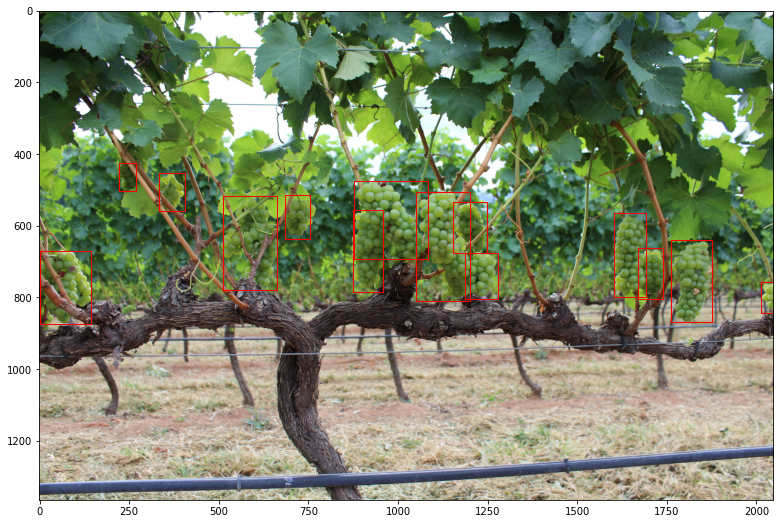

In [ ]:
sample = data_dir / 'SVB_1965.jpg'

def plot(sample, pic=0):
  plt.figure(figsize=(15, 9))
  plt.imshow(mpimg.imread(sample) / 255.)
  boxes = [s.strip().split() for s in list(open(data_dir / 'SVB_1965.txt'))]
  boxes = [[float(val) for val in arr] for arr in boxes]
  for box in boxes:
    width = box[3]
    height = box[4]
    bottom_left = (2048*(box[1] - width/2), 1365*(box[2] - height/2))
    plt.gca().add_patch(Rectangle((bottom_left),2048*width,1365*height,linewidth=1,edgecolor='r',facecolor='none'))

plot(sample)

# YOLO v3

In [ ]:
! git clone https://github.com/zzh8829/yolov3-tf2.git 

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 400 (delta 1), reused 1 (delta 0), pack-reused 394
Receiving objects: 100% (400/400), 4.23 MiB | 35.47 MiB/s, done.
Resolving deltas: 100% (231/231), done.


In [ ]:
%cd yolov3-tf2

/root/.keras/datasets/wgisd-master/data/yolov3-tf2


In [ ]:
! pip install -r requirements.txt &> /dev/null

In [ ]:
writer = tf.io.TFRecordWriter('./data/grape_train.tfrecord')
create_tfrecord(train_files, writer)
writer.close()
writer = tf.io.TFRecordWriter('./data/grape_valid.tfrecord')
create_tfrecord(valid_files, writer)
writer.close()

In [ ]:
with open('./data/classes.txt', 'w') as classes:
  classes.write('grapes')

In [ ]:
!python tools/visualize_dataset.py --classes=./data/classes.txt --dataset ./data/grape_train.tfrecord &> /dev/null

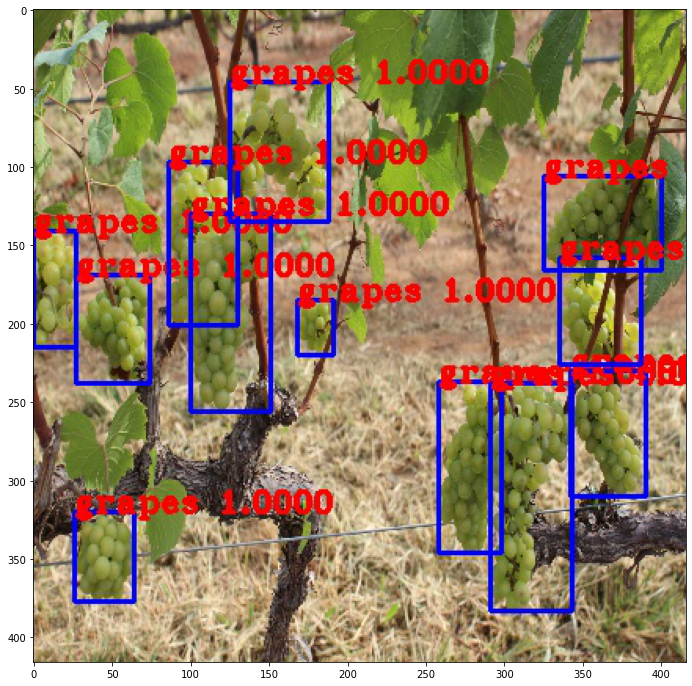

In [ ]:
plt.figure(figsize=(20, 12))
plt.imshow(mpimg.imread('output.jpg'))

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights 
!python convert.py &> /dev/null

--2021-02-02 20:00:46--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  2.57MB/s    in 69s     

2021-02-02 20:01:56 (3.41 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]



In [ ]:
!python train.py \
	--dataset ./data/grape_train.tfrecord \
	--val_dataset ./data/grape_valid.tfrecord \
  --classes ./data/classes.txt \
	--num_classes 1 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 50 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 \

2021-02-02 20:02:02.507046: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-02-02 20:02:02.507101: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-02-02 20:02:04.225479: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-02 20:02:04.226324: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-02 20:02:04.260543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-02 20:02:04.261128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:

In [ ]:
!ls ./checkpoints/

checkpoint				yolov3_train_23.tf.index
yolov3.tf.data-00000-of-00001		yolov3_train_24.tf.data-00000-of-00001
yolov3.tf.index				yolov3_train_24.tf.index
yolov3_train_10.tf.data-00000-of-00001	yolov3_train_25.tf.data-00000-of-00001
yolov3_train_10.tf.index		yolov3_train_25.tf.index
yolov3_train_11.tf.data-00000-of-00001	yolov3_train_26.tf.data-00000-of-00001
yolov3_train_11.tf.index		yolov3_train_26.tf.index
yolov3_train_12.tf.data-00000-of-00001	yolov3_train_27.tf.data-00000-of-00001
yolov3_train_12.tf.index		yolov3_train_27.tf.index
yolov3_train_13.tf.data-00000-of-00001	yolov3_train_28.tf.data-00000-of-00001
yolov3_train_13.tf.index		yolov3_train_28.tf.index
yolov3_train_14.tf.data-00000-of-00001	yolov3_train_29.tf.data-00000-of-00001
yolov3_train_14.tf.index		yolov3_train_29.tf.index
yolov3_train_15.tf.data-00000-of-00001	yolov3_train_2.tf.data-00000-of-00001
yolov3_train_15.tf.index		yolov3_train_2.tf.index
yolov3_train_16.tf.data-00000-of-00001	yolov3_train_30.tf.data-00000-of-000

In [ ]:
import random

sample = str(data_dir / random.choice(test_files)) + '.jpg'

!python detect.py \
	--num_classes 1 \
  --classes ./data/classes.txt \
	--weights ./checkpoints/yolov3_train_30.tf \
	--image {sample} \
  --yolo_score_threshold 0.08 &> /dev/null

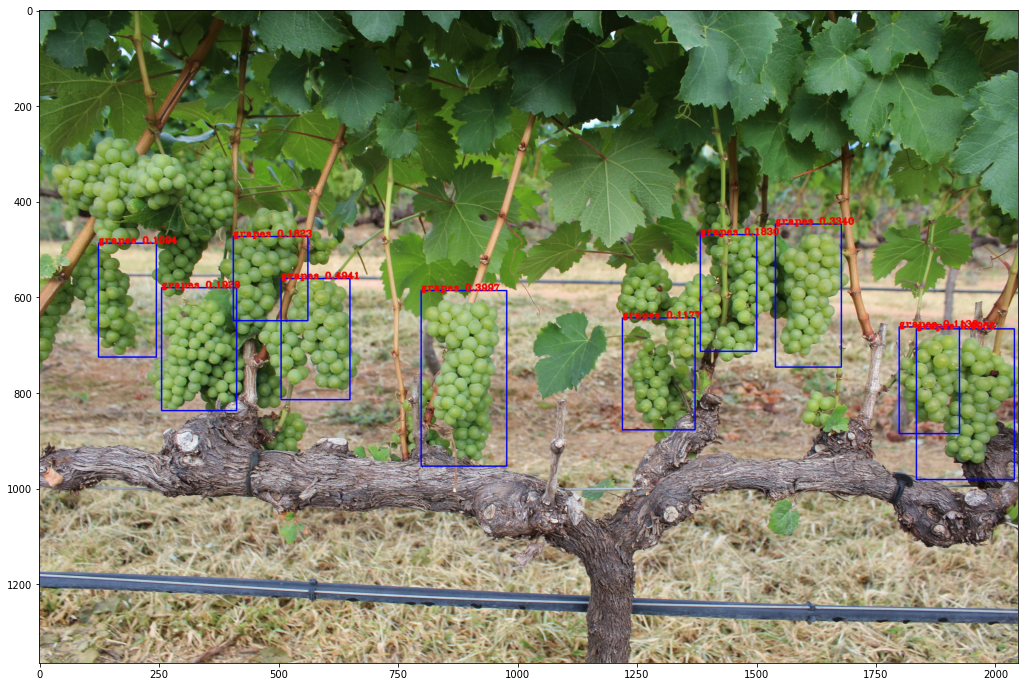

In [ ]:
plt.figure(figsize=(20, 12))
plt.imshow(mpimg.imread('output.jpg'))

# Faster R-CNN

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

# Install the Object Detection API
%cd models/research/
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install . &> /dev/null

import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

Cloning into 'models'...
remote: Enumerating objects: 2397, done.
remote: Counting objects: 100% (2397/2397), done.
remote: Compressing objects: 100% (1999/1999), done.
remote: Total 2397 (delta 571), reused 1389 (delta 371), pack-reused 0
Receiving objects: 100% (2397/2397), 30.77 MiB | 38.15 MiB/s, done.
Resolving deltas: 100% (571/571), done.
/root/.keras/datasets/wgisd-master/data/models/research


In [ ]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    threshold=0.8):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [ ]:
gt_boxes = []
train_images_np = []

for p in train_files:
    sample = str(data_dir / p)
    boxes = [s.strip().split() for s in list(open(sample + '.txt'))]
    boxes = [[float(val) for val in arr] for arr in boxes]

    xmin = [arr[1] - arr[3]/2 for arr in boxes]
    ymin = [arr[2] - arr[4]/2 for arr in boxes]
    xmax = [arr[1] + arr[3]/2 for arr in boxes]
    ymax = [arr[2] + arr[4]/2 for arr in boxes]

    gt_boxes.append(np.array([[ymin[i], xmin[i], ymax[i], xmax[i]] for i in range(len(boxes))], dtype=np.float32))
    train_images_np.append(mpimg.imread(sample + '.jpg')) 

In [ ]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


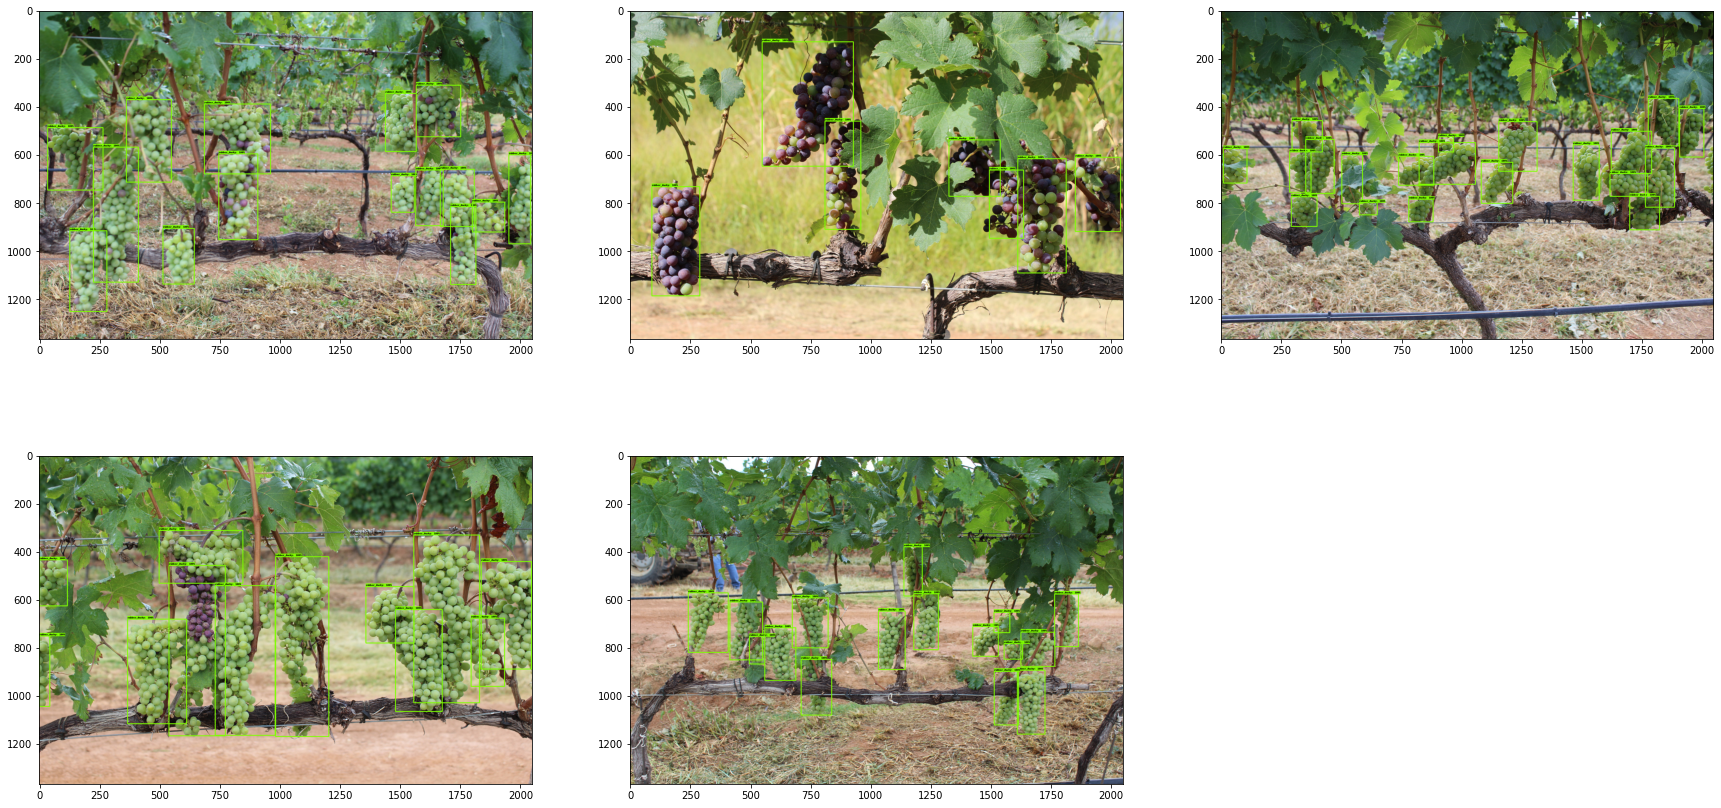

In [ ]:
dummy_scores = np.array([1.0] * 20, dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

In [ ]:
%cd ..
%cd ..

/root/.keras/datasets/wgisd-master/data/models
/root/.keras/datasets/wgisd-master/data


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-02-03 00:15:31--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.12.240, 2607:f8b0:4004:807::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.12.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  86.0MB/s    in 2.7s    

2021-02-03 00:15:34 (86.0 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
# ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [ ]:
tf.keras.backend.set_learning_phase(True)

batch_size = 4
learning_rate = 0.1
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 1000, loss=1.7982101
batch 10 of 1000, loss=1.7074335
batch 20 of 1000, loss=1.5066307
batch 30 of 1000, loss=1.407951
batch 40 of 1000, loss=1.2500107
batch 50 of 1000, loss=1.2631743
batch 60 of 1000, loss=1.2663004
batch 70 of 1000, loss=1.2265768
batch 80 of 1000, loss=1.2051558
batch 90 of 1000, loss=1.2850904
batch 100 of 1000, loss=1.2408671
batch 110 of 1000, loss=1.2246131
batch 120 of 1000, loss=1.2123246
batch 130 of 1000, loss=1.2458177
batch 140 of 1000, loss=1.2392676
batch 150 of 1000, loss=1.2904115
batch 160 of 1000, loss=1.185847
batch 170 of 1000, loss=1.2223926
batch 180 of 1000, loss=1.1785536
batch 190 of 1000, loss=1.3681736
batch 200 of 1000, loss=1.231661
batch 210 of 1000, loss=1.2450324
batch 220 of 1000, loss=1.4355696
batch 230 of 1000, loss=1.2303346
batch 240 of 1000, loss=1.2522867
batch 250 of 1000, loss=1.2817382
batch 260 of 1000, loss=1.2206267
batch 270 of 1000, loss=1.2642047
batch 280 of 1000, loss=1.2666292
batch 290 of 1000, loss=1.23

In [ ]:
test_images_np = []
for p in test_files:
  test_images_np.append(np.expand_dims(
      mpimg.imread(str(data_dir / p) + '.jpg'), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
# @tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), 
      image_name="gif_frame_" + ('%02d' % i) + ".jpg",
      threshold=0.01)

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_0*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=0.5)
display(IPyImage(open(anim_file, 'rb').read()))